In [1]:
# Cell 1: Imports and setup
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl
from tqdm import tqdm
from matplotlib.patches import Patch
from genometechlab_plotting import setup_style, get_colors
setup_style('inline')


Loaded 7 Helvetica fonts


In [2]:
# Use scan_csv for lazy loading - much faster for large files
lazy_df = pl.scan_csv(
    "../Exemplar_Data/modkit/08_07_24_R9RNA_GM12878_mRNA_RT_sup_8mods_polyA_sorted_filtered.chr12-112000000-114000000_isoquant_updated_extract_calls.bed",
    separator="\t",
    has_header=False,
    # Specify only the columns we actually need to reduce memory usage
    new_columns=[
        "chrom", "start", "stop", "mod", "proportion_modified", "strand", 
        "ref_base", "mod_count", "mod_fail", "A_Count", "T_Count", 
        "C_Count", "G_Count", "Isoform", "Gene"
    ]
)

# Apply coverage filter in lazy mode - operations are queued, not executed yet
coverage_filter_lazy = lazy_df.filter(
    ((pl.col("ref_base") == 'T') & (pl.col("T_Count") >= 20)) |
    ((pl.col("ref_base") == 'A') & (pl.col("A_Count") >= 20)) |
    ((pl.col("ref_base") == 'C') & (pl.col("C_Count") >= 20)) |
    ((pl.col("ref_base") == 'G') & (pl.col("G_Count") >= 20))
).select([  # Only select columns we actually need
    "start", "mod", "proportion_modified", "Isoform", "Gene"
])

# Now collect only the filtered data - this is when execution happens
coverage_filter_df = coverage_filter_lazy.collect()
print(f"Sites after coverage filter: {len(coverage_filter_df)}")

# Find genes with multiple isoforms (already collected, so this is fast)
eligible_genes = (
    coverage_filter_df
    .group_by("Gene")
    .agg(pl.col("Isoform").n_unique().alias("n_isoforms"))
    .filter(pl.col("n_isoforms") > 1)
    .select("Gene")
    .to_series()
    .to_list()
)
print(f"Genes with multiple isoforms: {len(eligible_genes)}")


Sites after coverage filter: 48358
Genes with multiple isoforms: 4


In [3]:
differences = {}

for gene in tqdm(eligible_genes, desc="Calculating differences"):
    sub_df = coverage_filter_df.filter(pl.col("Gene") == gene)
    
    # Pivot to get modification proportion by isoform
    wide = sub_df.pivot(
        index=["start", "mod"],
        on="Isoform",
        values="proportion_modified",
        aggregate_function="first"
    )
    
    # Get isoform columns
    isoform_cols = [c for c in wide.columns if c not in ["start", "mod"]]
    
    # Keep only sites with data in at least 2 isoforms
    wide = (
        wide
        .with_columns(
            pl.sum_horizontal([
                pl.col(c).is_not_null().cast(pl.Int32) 
                for c in isoform_cols
            ]).alias("n_isoforms")
        )
        .filter(pl.col("n_isoforms") >= 2)
    )
    
    # Keep only sites with at least one non-zero modification
    wide = wide.filter(
        pl.max_horizontal([
            pl.col(c).fill_null(0) 
            for c in isoform_cols
        ]) > 0.0
    )
    
    # Calculate max difference across isoforms
    # For min: fill nulls with 1.0 (max possible value for proportions)
    # For max: fill nulls with 0 (min possible value)
    wide = wide.with_columns(
        (pl.max_horizontal([pl.col(c).fill_null(0) for c in isoform_cols]) - 
         pl.min_horizontal([pl.col(c).fill_null(1.0) for c in isoform_cols])
        ).alias("max_diff")
    )
    
    if len(wide) > 0:
        differences[gene] = wide

print(f"Genes with differential modification: {len(differences)}")

high_diff_genes = [
    gene for gene in differences 
    if differences[gene].filter(pl.col("max_diff") >= 0.20).height > 0
]
print(f"High differential genes (≥20%): {len(high_diff_genes)}")

Calculating differences: 100%|██████████| 4/4 [00:00<00:00, 251.98it/s]

Genes with differential modification: 4
High differential genes (≥20%): 2


In [4]:
def get_max_diff_for_mod(differences, mod_code):
    """Extract maximum differences for a specific modification type."""
    max_diffs = []
    for gene in differences:
        gene_data = differences[gene]
        # Filter for this modification type
        mod_data = gene_data.filter(pl.col("mod") == mod_code)
        if len(mod_data) > 0:
            max_diffs.append(mod_data.select("max_diff").max().item())
    return max_diffs

# Calculate for each modification type
mod_types = {
    'Ino': '17596',   # Inosine
    'm6A': 'a',       # m6A
    'Psi': '17802',   # Pseudouridine
    'm5C': 'm'        # m5C
}
mod_max_diffs = {}
for mod_name, mod_code in mod_types.items():
    mod_max_diffs[mod_name] = get_max_diff_for_mod(differences, mod_code)
    print(f"{mod_name}: {len(mod_max_diffs[mod_name])} genes with differential sites")


Ino: 4 genes with differential sites
m6A: 4 genes with differential sites
Psi: 4 genes with differential sites
m5C: 4 genes with differential sites


In [5]:
# %matplotlib inline
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# axes = axes.flatten()
# for idx, (mod_name, mod_code) in enumerate(mod_types.items()):
#     if mod_max_diffs[mod_name]:
#         sns.histplot(
#             mod_max_diffs[mod_name], 
#             stat="density", 
#             binwidth=0.01, 
#             ax=axes[idx]
#         )
#         axes[idx].set_title(f"{mod_name} Differential Distribution")
#         axes[idx].set_xlabel("Max Differential Modification")
#         axes[idx].set_ylabel("Density")
# plt.tight_layout()
# plt.show()

In [6]:
def get_isoform_colors(gene_data, isoform_colors):
    """
    Determine color for each modification site based on isoform presence.
    
    Parameters:
    - gene_data: Polars DataFrame with proportion_modified for each isoform
    - isoform_colors: dict with keys 'iso1', 'iso2', 'both'
    
    Returns:
    - List of colors matching the order of sites
    """
    colors = []
    
    # Get the isoform column names
    isoform_cols = [c for c in gene_data.columns 
                    if c not in ["start", "mod", "max_diff", "n_isoforms"]]
    
    for row in gene_data.iter_rows(named=True):
        # Check which isoforms have this modification (non-null and > 0)
        present_isoforms = []
        for iso in isoform_cols:
            val = row.get(iso)
            if val is not None and val > 0:
                present_isoforms.append(iso)
        
        # Assign color based on presence
        if len(present_isoforms) == 1:
            # Only in one isoform - determine which one
            if present_isoforms[0] == isoform_cols[0]:
                colors.append(isoform_colors['iso1'])
            else:
                colors.append(isoform_colors['iso2'])
        elif len(present_isoforms) >= 2:
            # In both (or multiple) isoforms
            colors.append(isoform_colors['both'])
        else:
            # Shouldn't happen after filtering, but fallback
            colors.append('gray')
    
    return colors

# Define your color scheme
isoform_colors = {
    'iso1': '#1f77b4',  # Blue for isoform 1 only
    'iso2': '#ff7f0e',  # Orange for isoform 2 only
    'both': '#2ca02c'   # Green for both isoforms
}

In [7]:
n_genes_to_plot = 1
fig, axes = plt.subplots(n_genes_to_plot, 1, figsize=(12, 4*n_genes_to_plot))

if n_genes_to_plot == 1:
    axes = [axes]

for i in range(n_genes_to_plot):
    exemplar = high_diff_genes[i]
    
    # Extract data
    gene_data = differences[exemplar]
    starts = gene_data.select("start").to_series().to_list()
    mods = gene_data.select("mod").to_series().to_list()
    max_diff = gene_data.select("max_diff").to_series().to_list()
    
    # Get colors based on isoform presence
    colors = get_isoform_colors(gene_data, isoform_colors)
    
    # Plot
    axes[i].scatter(starts, max_diff, c=colors, s=50, alpha=0.7, 
                   edgecolors='black', linewidths=0.5)
    axes[i].set_ylim([0, 1.1])
    axes[i].set_title(f"Gene: {exemplar}")
    axes[i].set_xlabel("Genomic Position")
    axes[i].set_ylabel("Max Differential Modification")
    
    # Create custom legend
    legend_elements = [
        Patch(facecolor=isoform_colors['iso1'], label='Isoform 1 only'),
        Patch(facecolor=isoform_colors['iso2'], label='Isoform 2 only'),
        Patch(facecolor=isoform_colors['both'], label='Both isoforms')
    ]
    axes[i].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

/tmp/ipykernel_3320298/572374686.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Found modifications with >20% differential:
  m6A: 2 genes

Processing m6A - 2 genes
  ENSG00000111335.14:
    Total m6A sites: 74
    Sites in plot range: 37
    Sites >20%: 2
    Isoform 1 only: 30
    Isoform 2 only: 8
    Both isoforms: 36
    Range: 112,987,057 to 112,987,256
    Display range: 57 to 256
    Offset: 112,987,000
  ENSG00000123064.13:
    Total m6A sites: 179
    Sites in plot range: 18
    Sites >20%: 2
    Isoform 1 only: 85
    Isoform 2 only: 39
    Both isoforms: 55
    Range: 113,158,577 to 113,158,738
    Display range: 577 to 738
    Offset: 113,158,000


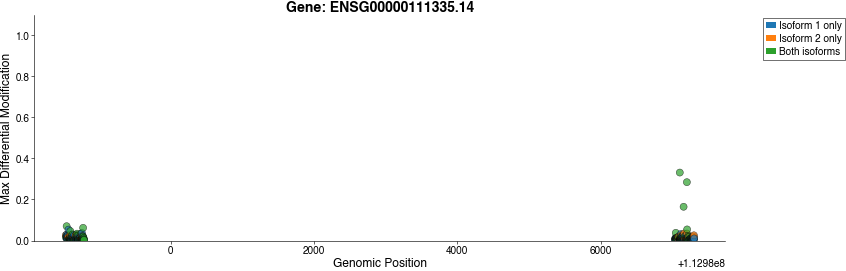

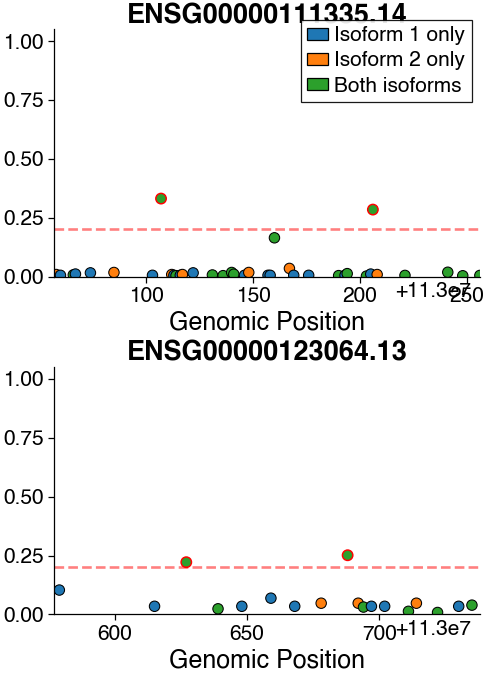

In [8]:
%matplotlib inline
# Cell 8: Publication figure - one figure per mod, all genes in subplots with isoform coloring

# Define readable modification names
mod_names = {
    'a': 'm6A',
    'm': 'm5C', 
    '17802': 'Pseudouridine',
    '17596': 'Inosine',
    '19227': '2′-O-Me (Am)',
    '19228': '2′-O-Me (Cm)',
    '19229': '2′-O-Me (Gm)',
    '69426': 'Unknown'
}

# Reverse mapping for looking up codes
mod_codes = {v: k for k, v in mod_names.items()}

# Color palette (keeping for reference, but using isoform colors now)
p = get_colors(8)
full_palette = {
    'm5C': p[1], 
    'm6A': p[0], 
    'Inosine': p[2], 
    'Pseudouridine': p[3],
    '2′-O-Me (Am)': p[4],
    '2′-O-Me (Cm)': p[5],
    '2′-O-Me (Gm)': p[6],
    'Unknown': p[7]
}

# How many genes to consider
n_genes_to_check = min(10, len(high_diff_genes))

# First, collect all modification types with >20% differential across all genes
all_mod_data = {}  # {mod_type: [(gene, data), (gene, data), ...]}

for gene_index in range(n_genes_to_check):
    exemplar = high_diff_genes[gene_index]
    gene_data = differences[exemplar]
    
    # Get modifications with >20% differential
    high_diff_mods = (
        gene_data
        .filter(pl.col("max_diff") > 0.2)
        .select("mod")
        .to_series()
        .unique()
        .to_list()
    )
    
    # Map to readable names
    high_diff_mod_types = set([mod_names.get(m, m) for m in high_diff_mods])
    
    # Store genes for each modification type
    for mod_type in high_diff_mod_types:
        if mod_type not in all_mod_data:
            all_mod_data[mod_type] = []
        all_mod_data[mod_type].append(exemplar)

print(f"Found modifications with >20% differential:")
for mod_type, gene_list in all_mod_data.items():
    print(f"  {mod_type}: {len(gene_list)} genes")

# Create one figure per modification type
for mod_type in sorted(all_mod_data.keys()):
    gene_list = all_mod_data[mod_type]
    n_genes = len(gene_list)
    
    print(f"\n{'='*80}")
    print(f"Processing {mod_type} - {n_genes} genes")
    print(f"{'='*80}")
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_genes, 1, figsize=(3.25, 4.5))
    if n_genes == 1:
        axes = [axes]
    
    mod_type_code = mod_codes.get(mod_type, mod_type)
    
    # Plot each gene
    for gene_idx, gene_name in enumerate(gene_list):
        ax = axes[gene_idx]
        full_gene_data = differences[gene_name]
        
        # Filter for this modification type
        filtered_gene_data = full_gene_data.filter(
            pl.col("mod") == mod_type_code
        )
        
        if len(filtered_gene_data) == 0:
            continue
        
        x_vals = filtered_gene_data.select("start").to_series().to_list()
        y_vals = filtered_gene_data.select("max_diff").to_series().to_list()
        
        # Get isoform-based colors
        point_colors = get_isoform_colors(filtered_gene_data, isoform_colors)
        
        # Find high differential sites (>20%) to determine x-axis range
        high_diff_sites = [x_vals[i] for i in range(len(x_vals)) if y_vals[i] > 0.2]
        
        if high_diff_sites:
            x_min = min(high_diff_sites) - 50
            x_max = max(high_diff_sites) + 50
        else:
            x_min = min(x_vals) - 50
            x_max = max(x_vals) + 50
        
        # **FILTER DATA TO ONLY POINTS WITHIN DISPLAY RANGE**
        in_range_mask = [(x >= x_min and x <= x_max) for x in x_vals]
        x_vals_filtered = [x for i, x in enumerate(x_vals) if in_range_mask[i]]
        y_vals_filtered = [y for i, y in enumerate(y_vals) if in_range_mask[i]]
        point_colors_filtered = [c for i, c in enumerate(point_colors) if in_range_mask[i]]
        
        # Calculate offset to make displayed numbers in 10s-1000s range
        span = x_max - x_min
        
        if span < 10000:
            offset = int(x_min // 1000) * 1000
        elif span < 100000:
            offset = int(x_min // 10000) * 10000
        else:
            offset = int(x_min // 100000) * 100000
        
        x_label = f"Genomic Position"
        
        # Transform x values (using filtered data)
        x_vals_transformed = [x - offset for x in x_vals_filtered]
        x_min_transformed = x_min - offset
        x_max_transformed = x_max - offset
        
        # Create edge colors and widths (using filtered data)
        edges = ['red' if diff > 0.2 else 'black' for diff in y_vals_filtered]
        widths = [0.7 if diff > 0.2 else 0.5 for diff in y_vals_filtered]
        
        # Plot with isoform colors and clip_on=True
        ax.scatter(x_vals_transformed, y_vals_filtered, c=point_colors_filtered, 
                  s=25, alpha=1.0, edgecolors=edges, linewidths=widths, 
                  clip_on=True)  # Prevents drawing outside axes
        
        # Set limits
        ax.set_xlim([x_min_transformed, x_max_transformed])
        ax.set_ylim([0, 1.05])
        
        # Add offset text in bottom right corner
        if offset >= 1e7:
            offset_text = f'+{offset/1e7:.1f}e7'
        elif offset >= 1e3:
            offset_text = f'+{offset/1e3:.1f}e3'
        elif offset >= 1e8:
            offset_text = f'+{offset/1e8:.1f}e8'
        else:
            offset_text = f'+{offset}'
        
        ax.text(0.98, -0.10, offset_text, transform=ax.transAxes,
                fontsize=10, verticalalignment='bottom', horizontalalignment='right')
        
        # Labels
        ax.set_xlabel(x_label, fontsize=12)
        ax.set_title(f"{gene_name}", fontsize=13)
        
        # Add horizontal line at 0.2 threshold
        ax.axhline(y=0.2, color='red', linestyle='--', linewidth=1.25, alpha=0.5)
        
        # Print statistics (using original unfiltered data for accurate counts)
        high_count = sum(1 for diff in y_vals if diff > 0.2)
        iso1_count = sum(1 for c in point_colors if c == isoform_colors['iso1'])
        iso2_count = sum(1 for c in point_colors if c == isoform_colors['iso2'])
        both_count = sum(1 for c in point_colors if c == isoform_colors['both'])
        
        print(f"  {gene_name}:")
        print(f"    Total {mod_type} sites: {len(x_vals)}")
        print(f"    Sites in plot range: {len(x_vals_filtered)}")
        print(f"    Sites >20%: {high_count}")
        print(f"    Isoform 1 only: {iso1_count}")
        print(f"    Isoform 2 only: {iso2_count}")
        print(f"    Both isoforms: {both_count}")
        print(f"    Range: {x_min:,} to {x_max:,}")
        print(f"    Display range: {x_min_transformed:.0f} to {x_max_transformed:.0f}")
        print(f"    Offset: {offset:,}")
    
    # Add legend
    legend_elements = [
        Patch(facecolor=isoform_colors['iso1'], edgecolor='black', label='Isoform 1 only'),
        Patch(facecolor=isoform_colors['iso2'], edgecolor='black', label='Isoform 2 only'),
        Patch(facecolor=isoform_colors['both'], edgecolor='black', label='Both isoforms')
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    # Save figure
    safe_mod_name = mod_type.replace('′', '').replace(' ', '_').replace('(', '').replace(')', '')
    plt.show()
